In [0]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


In [0]:
class Layer:

    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

In [0]:
# Class to handle forward and back propagation in a layer
class ModelHandler(Layer):

    def __init__(self, lr=0.0001):
        self.lr = lr
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self,X):
        for l in self.layers:
            X = l(X)
        return X

    def backward(self, gradient):
        for l in self.layers[::-1]:
            gradient = l.backward(gradient)

        return gradient

In [0]:
basicTransform = transforms.Compose([
    transforms.ToTensor(), 
])

In [0]:
ds = MNIST('./mnist', download=True, transform=basicTransform)


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
dataload = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 


In [0]:
class Linear(Layer):

    def __init__(self, inputVal, outputVal, lr=0.0001):
        self.A = 2*np.random.random((inputVal, outputVal)) - 1
        self.b = 2*np.random.random((outputVal)) - 1
        self.lr = lr

    def forward(self, X):
        self.X = X
        return np.dot(X,self.A) + self.b

    def backward(self, gradient):
        b_gradient = gradient.mean(axis=0)*self.X.shape[0]
        A_gradient = np.dot(self.X.T, gradient)
        # As this layer have somee weights we need to update them using 
        # gradient descent
        gradient_input = np.dot(gradient, self.A.T)

        self.A -= A_gradient * self.lr
        self.b -= b_gradient * self.lr

        return gradient_input

In [0]:
class Relu(Layer):

    def forward(self,X):
        self.X = X
        return np.maximum(np.zeros_like(X), X)

    def backward(self, gradient):
        gradient_input = (self.X > 0) * gradient
        return gradient_input

In [0]:
class SoftmaxCrossentropyWithLogits(Layer):

    def forward(self, X, Y):
        self.X = X
        self.Y = Y

        exp = np.exp(X) 
        self.softmax = exp / np.sum(exp, axis=-1, keepdims=True)

        logit = self.softmax[np.arange(X.shape[0]),Y]
        loglikelihood = -np.log(logit)
        loss = np.sum(loglikelihood) / X.shape[0]
        return loss

    def backward(self, gradient=None):
        batchshape = self.X.shape[0]
        gradient = self.softmax
        gradient[np.arange(batchshape),self.Y] -= 1
        gradient = gradient/batchshape
        return gradient

In [0]:
model = ModelHandler()


In [0]:
loss = SoftmaxCrossentropyWithLogits()


In [0]:
lossavg = 0 


In [0]:
for e in range(5):
    for i, (img, label) in enumerate(dataload):
        x = img.view(2,-1).numpy()

        res = model(x)
        _loss = loss(res, label.numpy())
        lossavg += _loss.mean() # running loss mean
        gradient = loss.backward(1)
        model.backward(gradient)

        if i % 100 == 0:
            print(lossavg/100)
            lossavg = 0
            print('---------')

2.183136739749663
---------
117.17098832661316
---------
75.58737104176431
---------
78.73164771410882
---------
66.75305781464988
---------
50.99935351556968
---------
56.95457839694436
---------
55.420952350612836
---------
41.1265804082381
---------
36.016246224565414
---------
37.71737160084396
---------
31.435922024098723
---------
30.373391275220527
---------
28.46271809503334
---------
36.35459925062798
---------
30.92909361052615
---------
26.964961175251055
---------
19.435994328704982
---------
24.7838109230377
---------
21.976361904740788
---------
19.310006633468983
---------
24.362111947847865
---------
22.01235091440102
---------
17.824886426012878
---------
20.768720985118662
---------
20.933741434803643
---------
21.49920341865873
---------
18.009391886114017
---------
18.297108616971894
---------
17.27677937637254
---------
18.175159762011116
---------
15.080340275451471
---------
15.630726054179593
---------
16.713098214251374
---------
14.893936512020757
---------
19

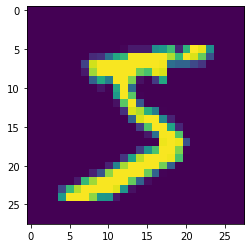

target: 5 predicted: 5


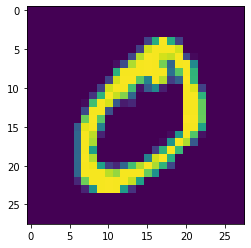

target: 0 predicted: 0


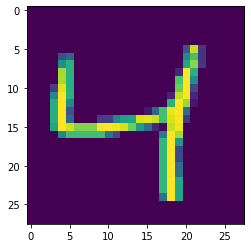

target: 4 predicted: 4


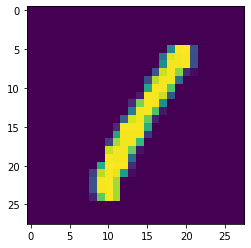

target: 1 predicted: 1


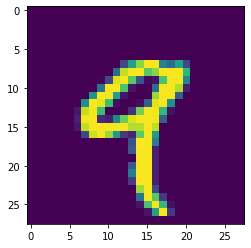

target: 9 predicted: 9


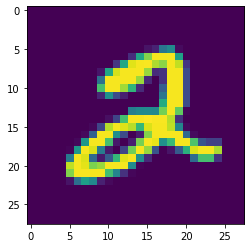

target: 2 predicted: 2


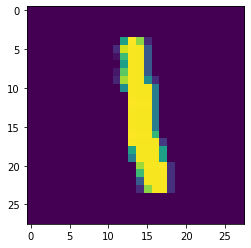

target: 1 predicted: 1


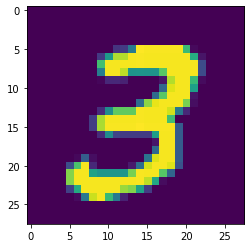

target: 3 predicted: 3


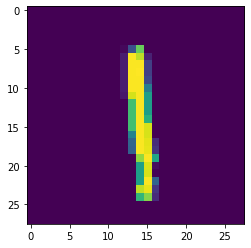

target: 1 predicted: 1


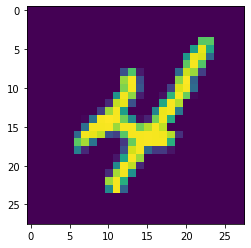

target: 4 predicted: 4


In [0]:
for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = model(x)[0]
    prediction = np.argmax(res)
    print(f'target: {target} predicted: {prediction}' )